# Import

In [1]:
import os
import sys

sys.path.append(os.path.abspath("../"))

import numpy as np
import matplotlib.pyplot as plt

from typing import List, Callable

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec

from nltk.tokenize import word_tokenize

from src.feed_forward.feed_forward_classifier import files_to_df, vectorize_text, clasification_from_model

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score

2024-05-18 12:45:15.628612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create datafram

In [4]:
files = [
        "BarackObamaSpeeches.csv",
        "BarackObamaDebates.csv",
        "BarackObamaTweets.csv",
        "DonaldTrumpDebates.csv",
        "DonaldTrumpspeeches.csv",
        "DonaldTrumpTweets.csv",
        "JoeBidenSpeeches.csv",
        "JoeBidenTweets.csv",
    ]
files = [os.path.join("../corpus/resources/", f) for f in files]
df = files_to_df(files)
names_to_keep = ['Barack Obama', 'Donald Trump', 'Joe Biden']

# Changer le nom en "other" si ce n'est pas dans la liste des noms à conserver
df['name'] = df['name'].apply(lambda x: x if x in names_to_keep else 'other')

# Definite word2vec and tokenizer

In [6]:
model_word2vec_path = '../src/word2vec/word2vecBest.model'
word2vec_model: Word2Vec = Word2Vec.load(model_word2vec_path)

tokenizer: Callable[[str], List[str]] = word_tokenize

# Vectorisation

In [7]:
def vectorize_text(text, word2vec_model: Word2Vec, tokenizer: Callable[[str], List[str]] = word_tokenize):
    tokens = tokenizer(text) 

    word_vectors = []
    for token in tokens:
        if token in word2vec_model.wv.key_to_index:
            word_vectors.append(word2vec_model.wv[token])
    
    if not word_vectors:
        return np.zeros(word2vec_model.vector_size)
    
    text_vector = np.mean(word_vectors, axis=0)
    return text_vector

In [8]:
df['text_embeddings'] = df['text'].apply(vectorize_text, args=(word2vec_model, tokenizer))
df

,name,text,text_embeddings
0,Barack Obama,"Mr. President, I have come to the floor today ...","[-0.14592953, 0.15516426, -0.25789413, -0.5349..."
1,Barack Obama,Thank you. It's an honor to be here today with...,"[-0.25582245, 0.08599489, -0.15229775, -0.4307..."
2,Barack Obama,"When I was first asked to speak here, I though...","[-0.1502317, 0.104145594, -0.27518904, -0.5698..."
3,Barack Obama,"Throughout American history, there have been m...","[-0.061100293, 0.3181456, -0.39384323, -0.3624..."
4,Barack Obama,Thank you. Half a century after the first few ...,"[-0.14999233, 0.12417714, -0.29248372, -0.4996..."
...,...,...,...
62296,Joe Biden,"As president, I’ll build an economy that rewar...","[0.16159704, -0.14173323, -0.40259805, -0.0009..."
62297,Joe Biden,Let’s put dogs back in the White House. https:...,"[0.4020463, -0.11940291, -1.0294363, -0.551373..."
62298,Joe Biden,We have in our hands the ultimate power: the p...,"[-0.052387785, -0.6381019, -0.3384863, -0.6108..."
62299,Joe Biden,"We need to:\n\nBuild bridges, not walls.\nOpen...","[0.1440064, 0.6309633, -0.5758265, 0.000754478..."


# Train

In [9]:
X = np.array(df['text_embeddings'].tolist())
Y = df['name']

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=72)

In [10]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(300,)),
    Dropout(0.31034557751664393),
    Dense(39, activation='relu'),
    Dropout(0.31034557751664393),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer=Adam(learning_rate=0.0012908313546078774), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, batch_size=64)
Y_pred = model.predict(X_test)

Epoch 1/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8300 - loss: 0.4815
Epoch 2/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8998 - loss: 0.2930
Epoch 3/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9113 - loss: 0.2586
Epoch 4/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9161 - loss: 0.2379
Epoch 5/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9244 - loss: 0.2222
Epoch 6/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9279 - loss: 0.2044
Epoch 7/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9332 - loss: 0.1920
Epoch 8/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9344 - loss: 0.1848
Epoch 9/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9362 - loss: 0.1805
Epoch 10/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9394 - loss: 0.1698
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


# Evaluation

In [12]:
Y_pred_decode = [label_encoder.classes_[np.argmax(x)] for x in Y_pred]
Y_test_decode = [label_encoder.classes_[x] for x in Y_test]

In [13]:
print("Classification Report:\n", classification_report(Y_test_decode, Y_pred_decode, labels=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

Barack Obama       0.86      0.84      0.85      1379
Donald Trump       0.95      0.98      0.96      9564
   Joe Biden       0.84      0.72      0.77      1334
       other       0.74      0.56      0.64       184

    accuracy                           0.93     12461
   macro avg       0.85      0.77      0.81     12461
weighted avg       0.93      0.93      0.93     12461



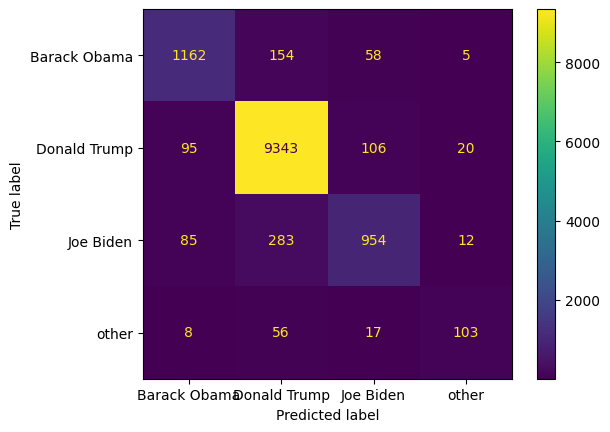

In [14]:
confusion = confusion_matrix(Y_test_decode, Y_pred_decode, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                               display_labels=label_encoder.classes_)

ax = plt.subplot(1, 1, 1)
ax.grid(False)
disp.plot(ax=ax)
plt.show()

# Test

In [15]:
predict_class = clasification_from_model('Thank you. It\'s an honor to be here today', model, word2vec_model,tokenizer)

print(label_encoder.classes_[predict_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Barack Obama


# Hyperparameter research

In [78]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

def create_model(trial):
    # Définir l'architecture du modèle en fonction des hyperparamètres
    num_hidden_units_1 = trial.suggest_int('num_hidden_units_1', 32, 128)
    num_hidden_units_2 = trial.suggest_int('num_hidden_units_2', 16, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    
    model = Sequential([
        Dense(num_hidden_units_1, activation='relu', input_shape=(300,)),
        Dropout(dropout_rate),
        Dense(num_hidden_units_2, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)
    
    model.fit(X_train, Y_train, 
              validation_data=(X_test, Y_test),
              epochs=10, 
              batch_size=64, 
              verbose=0)
    
    score = model.evaluate(X_test, Y_test, verbose=0)
    return score[1]  # Utiliser la précision comme mesure d'objectif

# Créer l'étude Optuna et optimiser
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters: ', study.best_params)



[I 2024-05-18 12:03:14,017] A new study created in memory with name: no-name-362f0863-4991-47fd-b335-f0ffba4cc1a4
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-05-18 12:03:27,385] Trial 0 finished with value: 0.925848662853241 and parameters: {'num_hidden_units_1': 125, 'num_hidden_units_2': 38, 'dropout_rate': 0.44753137810297183, 'learning_rate': 0.000695691744072681}. Best is trial 0 with value: 0.925848662853241.
[I 2024-05-18 12:03:42,755] Trial 1 finished with value: 0.9274536371231079 and parameters: {'num_hidden_units_1': 128, 'num_hidden_units_2': 42, 'dropout_rate': 0.2722935239562355, 'learning_rate': 0.00028736119268954734}. Best is trial 1 with v

Best hyperparameters:  {'num_hidden_units_1': 128, 'num_hidden_units_2': 39, 'dropout_rate': 0.31034557751664393, 'learning_rate': 0.0012908313546078774}
